## SHAP, LRP & attention scores with Attention-LSTM
Author: Lin Lee Cheong <br>
Modified by: Tesfagabir Meharizghi
Date created: 1/13/2021 <br>
Date updated: 2/10/2021 <br>

**Data:** <br>
Using the final version of 30 sequence length dataset (sequence-based) generated by Tes<br>
Train, validation (for model training), test (for performance etc), and example (4 output)
<br>


**Steps:** <br>
1. Read in datasets [DONE]
2. LSTM model training 
    - TODO: check probab outputs
    - save epoch train, val, loss, etc [DONE]
    - calculated SHAP & relevance scores for val and test sets [DONE]
    - calculate rbo, tau for val and test sets [DONE]
    - plot rbo, tau
3. Extract SHAP, attention and relevance scores for a TEST set
    - calculate SHAP, relevance scores, performance (AUC, test loss)[DONE]
    - calculate rbo, tau [DONE]
3. Extract SHAP and relevance scores for example set of 4
    - plot epoch evolution [DONE]
    - add attention [DONE]
4. Save output in dict format[DONE]

#Params tried: 
* 10, 10 ==> Not good

In [3]:
#!python lstm.py

In [4]:
#!pip install rbo

In [5]:
#!python -m pip install --upgrade pip

In [6]:
#! pip install shap
#!pip install xgboost
#!pip install -e git+https://github.com/changyaochen/rbo.git@master#egg=rbo

#!pip install nb_black

In [1]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [1]:
import sys

sys.path.append("../")

import os
import json
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import numpy as np
from numpy import newaxis as na

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *

# from lrp_att_model import *
import shap_jacc_utils as sj_utils

from cdiff_utils import *

# import rbo

In [2]:
# Extra - removing leaked data from balanced training data.

In [3]:
# def is_not_available(row, patient_ids):
#     """If patient id is not available in the given list/set."""
#     patient_id = row["patient_id"]
#     if patient_id not in patient_ids:
#         return True
#     return False

DATA_TYPE = "original"
FNAME = "20110101"
#TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/downsampled/preprocessed_v2/splits/all/train.csv"
# TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/train.csv"
VALID_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/val.csv"
TEST_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/test.csv"
#OUT_TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/train_balanced.csv"

# # df_train = pd.read_csv(TRAIN_DATA_PATH)
# df_val = pd.read_csv(VALID_DATA_PATH)
# df_test = pd.read_csv(TEST_DATA_PATH)

# df_val["patient_id"] = df_val["patient_id"] + f"_{FNAME}"
# df_test["patient_id"] = df_test["patient_id"] + f"_{FNAME}"

# val_test_patients = set(
#     df_val.patient_id.values.tolist() + df_test.patient_id.values.tolist()
# )

# results = df_train.apply(is_not_available, args=(val_test_patients,), axis=1)
# results = results.tolist()
# df_train2 = df_train[results]
# df_train2.to_csv(OUT_TRAIN_DATA_PATH, index=False)
# #End of Data Leakage

In [18]:
VALID_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI_Research/model/toy_simple/AE_CDiff/output-mix/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/1000/val.csv'
TEST_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI_Research/model/toy_simple/AE_CDiff/output-mix/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/1000/test.csv'

OUT_VALID_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI_Research/model/toy_simple/AE_CDiff/output-mix/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/1000/val_positives_first.csv'
OUT_TEST_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI_Research/model/toy_simple/AE_CDiff/output-mix/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/1000/test_positives_first.csv'

In [9]:
# df_train = pd.read_csv(TRAIN_DATA_PATH)
df_val = pd.read_csv(VALID_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

In [10]:
df_val.head()

,999,998,997,996,995,994,993,992,991,990,...,5,4,3,2,1,0,d_00845,patient_id,num_gt_codes,has_gt_codes
0,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_7936,h_72193,h_74160,h_99285,h_A0425,h_A0429,0,TXW0XBNHS,12,1
1,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_4289_rf,h_99213,5_days,d_4280_rf,h_E1390,p_D1C,0,HVJ6XSQQV,11,1
2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,discharge,7_days,d_1540_rf,d_7949,h_78815,h_A9552,0,P81YE3JUU,11,1
3,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_99213,28_days,h_3CFKV,h_G0154,7_days,h_G0154,0,Q9K9DMU8A,10,1
4,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_36250,h_92004,h_99305,9_days,d_4659,h_99308,0,LBNMJ4ZIW,10,1


In [11]:
cols = ['d_00845', 'num_gt_codes']

In [12]:
df_val = df_val.sort_values(cols, ascending=False).reset_index(drop=True)
df_val.head()

,999,998,997,996,995,994,993,992,991,990,...,5,4,3,2,1,0,d_00845,patient_id,num_gt_codes,has_gt_codes
0,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_25000,d_41400,h_36415,h_99214,11_days,d_00845_rf,1,RPT0GHF5R,6,1
1,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,23_days,d_5859_rf,h_90960,h_90999,h_A4657,h_Q4081,1,HJOVD2D0C,6,1
2,1_days,d_25042,d_4019,d_4280_rf,d_4439,h_85046,h_A0425,h_A0428,2_days,d_4019,...,d_4439,h_A0425,h_A0428,1_days,d_5856_rf,h_90960,1,87MLKUGB9,6,1
3,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,1_days,d_00845_rf,d_4011,h_99232,1_days,discharge,1,4NFU59APD,5,1
4,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_78552,d_7862,d_V5881,h_71010,h_99291,admission,1,DJYNNXLB5,5,1


In [13]:
df_test = df_test.sort_values(cols, ascending=False).reset_index(drop=True)
df_test.head()

,999,998,997,996,995,994,993,992,991,990,...,5,4,3,2,1,0,d_00845,patient_id,num_gt_codes,has_gt_codes
0,d_2809,h_36415,h_85025,h_99213,5_days,d_6827,h_99213,3_days,d_2809,h_36415,...,h_99233,1_days,d_2639,d_42731,h_99232,h_99233,1,SH8FMNYIU,6,1
1,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,9_days,d_1101,d_25073,h_11056,h_11721,h_99304,1,RMUKOV6H2,6,1
2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_00845_rf,d_5789,h_99232,1_days,d_5789,h_99232,1,9J81XOB5H,5,1
3,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_99284,h_A0425,h_A0429,1_days,d_496_rf,h_99308,1,612C5OXLI,5,1
4,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,p_4525_rf,p_4824_rf,1_days,d_5579,h_99238,discharge,1,7Z1906X18,5,1


In [15]:
df_test['d_00845'].value_counts()

0    248494
1       160
Name: d_00845, dtype: int64

In [16]:
df_val['d_00845'].value_counts()

0    248494
1       159
Name: d_00845, dtype: int64

In [19]:
df_val.to_csv(OUT_VALID_DATA_PATH)
df_test.to_csv(OUT_TEST_DATA_PATH)

In [4]:
MODEL_NAME = "lstm-att-lrp"

NROWS = 1e9

TRAIN_MODEL = False
SEQ_LEN = 100

N_EPOCHS = 10

TARGET_COLNAME = "d_00845"
UID_COLNAME = "patient_id"
TARGET_VALUE = "1"

DATA_TYPE = "original"  # "downsampled"
FNAME = "20110101"  # "all"
SAVE_DATASET = True

BATCH_SIZE = 64
# Model Parameters
MODEL_PARAMS = {
    # Dataset/vocab related
    "min_freq": 20000,
    "batch_size": BATCH_SIZE,
    # Model related parameters
    "embedding_dim": 30,  # 30
    "hidden_dim": 30,  # 30
    "nlayers": 1,
    "bidirectional": True,
    "dropout": 0.3,
    "linear_bias": False,
    "init_type": "zero",  # zero/learned
    "learning_rate": 0.01,
    "scheduler_step": 3,
    "clip": True,
    "rev": False,
    # SHAP-related parameters
    "n_background": 300,  # Number of background examples
    "background_negative_only": False,  # If negative examples are used as background
    "background_positive_only": False,
    "test_positive_only": False,
    "is_test_random": False,
    "n_valid_examples": BATCH_SIZE,  # Number of validation examples to be used during shap computation
    "n_test_examples": BATCH_SIZE,  # Number of the final test examples to be used in shap computation #TODO
}

# ALL_DOWN_DATA_PATH = (
#     f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/all.csv"
# )

# MONTH_DATA_PATH = (
#     f"../../../data/AE_CDiff_d00845/output/data/1000/original/preprocessed_v2/20110101.csv"
# )

TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/train.csv"
VALID_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/val.csv"
TEST_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/test.csv"
# SELECTED_EXAMPLES_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/visualized_test_patients.txt"

OUT_TRAIN_DATA_PATH = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/train.csv"
OUT_VALID_DATA_PATH = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/val.csv"
OUT_TEST_DATA_PATH = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/test.csv"
SELECTED_EXAMPLES_PATH = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/visualized_test_patients.txt"

VOCAB_PATH = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/vocab.pkl"

GT_CODES_PATH = "../../../data/AE_CDiff_d00845/cdiff_risk_factors_codes.csv"

MODEL_SAVE_PATH_PATTERN = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/model_weights/model_{'{}'}.pkl"
SHAP_SAVE_DIR_PATTERN = f"./output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split

OUTPUT_RESULTS_PATH = f"output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/train_results/results.csv"
PARAMS_PATH = f"output/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/train_results/model_params.json"

# --------------------
# From the original AE parameters
# batch_size = 1024
# N_EPOCHS = 20

# EMBEDDING_DIM = 30
# HIDDEN_DIM = 30
# BIDIRECTIONAL = False
# DROPOUT = 0.3
# -------------------

In [5]:
# df_train = pd.read_csv(TRAIN_DATA_PATH)
df_val = pd.read_csv(VALID_DATA_PATH)
# df_test = pd.read_csv(TEST_DATA_PATH)

In [6]:
# df_train.shape, df_val.shape, df_test.shape

In [7]:
df_val.shape

(248653, 1004)

In [8]:
df_val['d_00845'].value_counts()

0    248494
1       159
Name: d_00845, dtype: int64

In [81]:
df_val.head(10)

,999,998,997,996,995,994,993,992,991,990,...,5,4,3,2,1,0,d_00845,patient_id,num_gt_codes,has_gt_codes
0,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_2722,d_78079,d_V5869,h_36415,h_80053,h_80061,0,30JUSFQDS,1,1
1,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,7_days,d_4770,h_99214,32_days,d_71535,h_99203,0,QWD7ILLRT,1,1
2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_Q0511,p_O1E,5_days,d_42731,h_36415,h_85610,0,OTUVKH2JA,13,1
3,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_2113,d_V711,d_V7651,h_00810,h_45378_rf,h_45385,0,OWJYQN5IV,1,1
4,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_99213,12_days,d_7020,d_70211,h_17000,h_17110,0,2QN0C0TEM,5,1
5,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_2724,h_99213,17_days,d_V0481,h_90656,h_G0008,0,MDQN5PRLD,2,1
6,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_81001,h_86663,h_86665,131_days,d_5856_rf,h_90966,0,T7UAVJVRP,7,1
7,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,2_days,d_29634,h_96118,11_days,d_496_rf,h_E1390,0,1SR5TN4PN,30,1
8,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_28521,d_2859,d_5856_rf,h_99221,h_99232,h_99233,0,0HH1WPJSU,39,1
9,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,d_6271,h_00952,h_58558_rf,h_88305,0,TE7DQZQHM,1,1


In [9]:
# Create output directories if needed
model_dir = os.path.dirname(MODEL_SAVE_PATH_PATTERN)
shap_dir = os.path.dirname(SHAP_SAVE_DIR_PATTERN)
output_dir = os.path.dirname(OUTPUT_RESULTS_PATH)

In [10]:
if TRAIN_MODEL:
    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
    if os.path.exists(shap_dir):
        shutil.rmtree(shap_dir)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(model_dir)
    os.makedirs(shap_dir)
    os.makedirs(output_dir)
    print(f"Directory Created: {model_dir}")
    print(f"Directory Created: {shap_dir}")
    print(f"Directory Created: {output_dir}")

In [11]:
gt_codes = pd.read_csv(GT_CODES_PATH)
gt_codes = list(set(gt_codes.Internal_Code))
len(gt_codes)

135

In [13]:
# if TRAIN_MODEL:
#     df = pd.read_csv(TRAIN_DATA_PATH)
#     df_val = pd.read_csv(VALID_DATA_PATH)
#     df_test = pd.read_csv(TEST_DATA_PATH)

#     # Take upto seq_len cols
#     # cols = df.columns.tolist()
#     # exclude = [str(i) for i in range(1000, SEQ_LEN, -1)]
#     # cols = [col for col in cols if col not in exclude]
#     # df = df[cols]
#     # df.head()

#     cols = [str(i) for i in range(SEQ_LEN - 1, -1, -1)]
#     vocab = Counter(df[cols].values.flatten().tolist())

#     # Remove tokens not in gt_codes
#     for token in list(vocab):
#         if (not token.endswith('_rf')):
#             del vocab[token]
#     print(len(vocab))

#     df["num_gt_codes"] = df.apply(
#         get_gt_code_patient, args=(SEQ_LEN,), axis=1
#     )
#     df["has_gt_codes"] = (df["num_gt_codes"] > 0).astype(int)
#     df = df.sort_values("has_gt_codes", ascending=False)

#     df_val["num_gt_codes"] = df_val.apply(
#         get_gt_code_patient, args=(SEQ_LEN,), axis=1
#     )
#     df_val["has_gt_codes"] = (df_val["num_gt_codes"] > 0).astype(int)
#     df_val = df_val.sort_values("has_gt_codes", ascending=False)

#     df_test["num_gt_codes"] = df_test.apply(
#         get_gt_code_patient, args=(SEQ_LEN,), axis=1
#     )
#     df_test["has_gt_codes"] = (df_test["num_gt_codes"] > 0).astype(int)
#     df_test = df_test.sort_values("has_gt_codes", ascending=False)

#     out_dir = os.path.dirname(OUT_TRAIN_DATA_PATH)
#     os.makedirs(out_dir, exist_ok=True)

#     df.to_csv(OUT_TRAIN_DATA_PATH, index=False)
#     df_val.to_csv(OUT_VALID_DATA_PATH, index=False)
#     df_test.to_csv(OUT_TEST_DATA_PATH, index=False)
# else:
#     pass
# #     df_train = pd.read_csv(OUT_TRAIN_DATA_PATH)
# #     df_val = pd.read_csv(OUT_VALID_DATA_PATH)
# #     df_test = pd.read_csv(OUT_TEST_DATA_PATH)

In [14]:
# df_train = pd.read_csv(OUT_TRAIN_DATA_PATH)
# print(df_train.shape)
# df_train.head()

In [15]:
# df_train[TARGET_COLNAME].value_counts()

In [16]:
# df_val = pd.read_csv(OUT_TEST_DATA_PATH)
# print(df_val.shape)
# df_val.head(20)

In [17]:
# df_val[TARGET_COLNAME].value_counts()

In [18]:
# df_val.head()

In [19]:
# print("# of Examples with and without Risk Factors")
# print(df_train.has_gt_codes.value_counts())
# print("-" * 20)
# df_train["num_gt_codes"].plot.hist(bins=10)
# plt.xlabel("Number of Accurrences of Ground Truth Risk Factors/Patient")
# plt.title("Histogram of GT Risk Factors per Patient")
# plt.show()

In [20]:
# del df_train

In [21]:
# df_test = pd.read_csv(OUT_TEST_DATA_PATH)

In [23]:
SELECTED_EXAMPLES_PATH

'./output/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/20000/visualized_test_examples.txt'

In [25]:
if TRAIN_MODEL:
    pos_examples = df_test[df_test["d_00845"] == 1]["patient_id"].iloc[:2].tolist()
    neg_examples = df_test[df_test["d_00845"] == 0]["patient_id"].iloc[:2].tolist()
    test_examples = pos_examples + neg_examples

    with open(SELECTED_EXAMPLES_PATH, "w") as fp:
        fp.write("\n".join(test_examples))
else:
    patients = (
        pd.read_csv(SELECTED_EXAMPLES_PATH, sep=" ", header=None)
        .values.flatten()
        .tolist()
    )

In [26]:
patients

In [27]:
# del df_test

In [28]:
# Check if cuda is available
print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [29]:
MULTIGPU_LST = []
if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    for gpu in range(n_gpus):
        MULTIGPU_LST.append(f"cuda:{gpu}")

In [30]:
# Load Selected Patients for later SHAP visualization
selected_patients = patients[:]
print(f"Selected Test Examples: {patients}")
# create the example set
selected_patients_path = os.path.join(output_dir, "selected_test_patients.csv")
test_df = pd.read_csv(OUT_TEST_DATA_PATH)
test_df[test_df.patient_id.isin(patients)].to_csv(selected_patients_path, index=False)

In [31]:
pd.read_csv(selected_patients_path).head()

In [32]:
print(test_df.shape)
test_df.head()

In [33]:
del test_df

## 1. Define and create Dataloaders

In [35]:
vocab = None
if not TRAIN_MODEL:
    with open(vocab_path, 'wb') as fp:
        vocab = pickle.load(fp)
        
train_dataset, vocab = build_lstm_dataset(
    OUT_TRAIN_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
    cdiff=True,
)

valid_dataset, _ = build_lstm_dataset(
    OUT_VALID_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
)

test_dataset, _ = build_lstm_dataset(
    OUT_TEST_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
)

example_dataset, _ = build_lstm_dataset(
    selected_patients_path,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
)

Building dataset from ./output/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/20000/train.csv..
Success!
Building dataset from ./output/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/20000/val.csv..
Success!
Building dataset from ./output/AE_CDiff/100/original/lstm-att-lrp/splits/20110101/20000/test.csv..
Success!


In [36]:
train_dataloader = DataLoader(
    train_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

example_dataloader = DataLoader(
    example_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

In [37]:
print(f"Total Vocab: {len(vocab._vocab)}")

Total Vocab: 978


In [38]:
gt_codes, _ = get_ground_truth_codes(GT_CODES_PATH, vocab, SEQ_LEN)

Total GT codes original: 135
Total vocab: 978
Total GT Available: 453


## LSTM Model Training

### Define and load LRP LSTM model

In [39]:
if not TRAIN_MODEL:
    # LOAD Model Parameters
    with open(PARAMS_PATH, "r") as fp:
        MODEL_PARAMS = json.load(fp)

lstm_model = AttNoHtLSTM(
    MODEL_PARAMS["embedding_dim"],
    MODEL_PARAMS["hidden_dim"],
    vocab,
    model_device,
    bidi=MODEL_PARAMS["bidirectional"],
    nlayers=MODEL_PARAMS["nlayers"],
    dropout=MODEL_PARAMS["dropout"],
    init_type=MODEL_PARAMS["init_type"],
    linear_bias=MODEL_PARAMS["linear_bias"],
)

In [40]:
lstm_model

AttNoHtLSTM(
  (emb_layer): Embedding(978, 32, padding_idx=0)
  (lstm): LSTM(32, 20, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=40, out_features=1, bias=False)
  (dpt): Dropout(p=0.0, inplace=False)
)

In [41]:
lstm_model.device

device(type='cuda', index=0)

In [42]:
lstm_model.cuda()

AttNoHtLSTM(
  (emb_layer): Embedding(978, 32, padding_idx=0)
  (lstm): LSTM(32, 20, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=40, out_features=1, bias=False)
  (dpt): Dropout(p=0.0, inplace=False)
)

In [43]:
model = lstm_model.cpu()

In [44]:
model.device

device(type='cuda', index=0)

### Train LSTM model

In [45]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    lstm_model.parameters(), lr=MODEL_PARAMS["learning_rate"], weight_decay=0.03
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, MODEL_PARAMS["scheduler_step"], gamma=0.9
)

# optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=0.0001, weight_decay=0.02)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 11, gamma=0.8)

In [46]:
lstm_model = lstm_model.to(model_device)

In [47]:
# epoch = 5
# model_path = MODEL_SAVE_PATH_PATTERN.format(
#     str(epoch).zfill(2)
# )  # TODO: Remove this once done
# print(model_path)
# lstm_model.load_state_dict(torch.load(model_path))

In [14]:
valid_results = {}
test_results = {}

rbo_p = 0.8
SIMILARITY_FREEDOM = 1  # For Intersection Similarity

if TRAIN_MODEL:
    train_auc_lst = []
    train_loss_lst = []

    val_auc_lst = []
    val_loss_lst = []
    val_lrp_sim_lst = []
    val_shap_sim_lst = []
    val_lrp_shap_rbo_lst = []
    val_lrp_shap_tau_lst = []

    test_auc_lst = []
    test_loss_lst = []
    test_lrp_sim_lst = []
    test_shap_sim_lst = []
    test_lrp_shap_rbo_lst = []
    test_lrp_shap_tau_lst = []

    val_patient_ids, val_labels, val_idxed_text = next(iter(valid_dataloader))
    test_patient_ids, test_labels, test_idxed_text = next(iter(test_dataloader))

    # patient_ids, labels, idxed_text = get_sub_valid_data(N_VALID_EXAMPLES, MODEL_PARAMS['batch_size'], valid_dataloader)

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        # import pdb; pdb.set_trace()
        lstm_model.train()
        # model training & perf evaluation
        train_loss, train_auc = epoch_train_lstm(
            lstm_model,
            train_dataloader,
            optimizer,
            loss_function,
            clip=MODEL_PARAMS["clip"],
            device=model_device,
        )
        train_auc_lst.append(train_auc)
        train_loss_lst.append(train_loss)

        valid_loss, valid_auc = epoch_val_lstm(
            lstm_model, valid_dataloader, loss_function, device=model_device
        )
        val_auc_lst.append(valid_auc)
        val_loss_lst.append(valid_loss)

        test_loss, test_auc = epoch_val_lstm(
            lstm_model, test_dataloader, loss_function, device=model_device
        )
        test_auc_lst.append(test_auc)
        test_loss_lst.append(test_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # save model
        save_path = MODEL_SAVE_PATH_PATTERN.format(str(epoch).zfill(2))
        torch.save(lstm_model.state_dict(), save_path)

        scheduler.step()

        #         print(
        #             f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} "
        #             + f"\t Val. Loss: {valid_loss:.4f} | Val. AUC: {valid_auc:.4f} "
        #             + f"\t Test. Loss: {test_loss:.4f} | Test. AUC: {test_auc:.4f} "
        #         )
        #         continue

        # calculate relevancy and SHAP
        lstm_model.eval()
        lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())

        # Save valid/test results
        valid_results[epoch] = {}
        test_results[epoch] = {}

        for sel_idx in range(len(val_labels)):
            one_text = [
                int(token.numpy())
                for token in val_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if val_patient_ids[sel_idx] not in valid_results[epoch]:
                valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]]["label"] = val_labels[
                sel_idx
            ]
            valid_results[epoch][val_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            valid_results[epoch][val_patient_ids[sel_idx]]["imp"] = df.copy()

        for sel_idx in range(len(test_labels)):
            one_text = [
                int(token.numpy())
                for token in test_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if test_patient_ids[sel_idx] not in test_results[epoch]:
                test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]]["label"] = test_labels[
                sel_idx
            ]
            test_results[epoch][test_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            test_results[epoch][test_patient_ids[sel_idx]]["imp"] = df.copy()

        shap_start_time = time.time()
        (
            val_features,
            val_scores,
            val_patients,
        ) = sj_utils.get_lstm_features_and_shap_scores(
            lstm_model.cuda(),
            train_dataloader,
            valid_dataloader,
            SEQ_LEN,
            "",
            save_output=False,
            n_background=MODEL_PARAMS["n_background"],
            background_negative_only=MODEL_PARAMS["background_negative_only"],
            n_test=MODEL_PARAMS["n_valid_examples"],
            test_positive_only=MODEL_PARAMS["test_positive_only"],
            is_test_random=MODEL_PARAMS["is_test_random"],
        )

        (
            test_features,
            test_scores,
            test_patients,
        ) = sj_utils.get_lstm_features_and_shap_scores(
            lstm_model.cuda(),
            train_dataloader,
            test_dataloader,
            SEQ_LEN,
            "",
            save_output=False,
            n_background=MODEL_PARAMS["n_background"],
            background_negative_only=MODEL_PARAMS["background_negative_only"],
            n_test=MODEL_PARAMS["n_valid_examples"],
            test_positive_only=MODEL_PARAMS["test_positive_only"],
            is_test_random=MODEL_PARAMS["is_test_random"],
        )

        #         (
        #             val_features,
        #             val_scores,
        #             val_patients,
        #         ) = get_lstm_features_and_shap_scores_mp(
        #             lstm_model.cpu(),
        #             train_dataloader,
        #             (val_patient_ids, val_labels, val_idxed_text),
        #             SEQ_LEN,
        #             "",
        #             save_output=False,
        #             n_background=MODEL_PARAMS["n_background"],
        #             background_negative_only=MODEL_PARAMS["background_negative_only"],
        #             test_positive_only=MODEL_PARAMS["test_positive_only"],
        #             is_test_random=MODEL_PARAMS["is_test_random"],
        #             multigpu_lst=MULTIGPU_LST,  # ["cuda:2", "cuda:3", "cuda:1"],
        #         )

        #         (
        #             test_features,
        #             test_scores,
        #             test_patients,
        #         ) = get_lstm_features_and_shap_scores_mp(
        #             lstm_model.cpu(),
        #             train_dataloader,
        #             (test_patient_ids, test_labels, test_idxed_text),
        #             SEQ_LEN,
        #             "",
        #             save_output=False,
        #             n_background=MODEL_PARAMS["n_background"],
        #             background_negative_only=MODEL_PARAMS["background_negative_only"],
        #             test_positive_only=MODEL_PARAMS["test_positive_only"],
        #             is_test_random=MODEL_PARAMS["is_test_random"],
        #             multigpu_lst=MULTIGPU_LST,  # ["cuda:2", "cuda:3", "cuda:1"],
        #         )

        shap_end_time = time.time()
        shap_mins, shap_secs = epoch_time(shap_start_time, shap_end_time)

        for idx, pid in enumerate(val_patients):
            df = valid_results[epoch][pid]["imp"]
            assert len(df) == len(val_scores[idx])
            df["shap_scores"] = val_scores[idx]
            df = df[
                ["idx", "seq_idx", "token", "att_weights", "lrp_scores", "shap_scores"]
            ]
            valid_results[epoch][pid]["imp"] = df.copy()

        for idx, pid in enumerate(test_patients):
            df = test_results[epoch][pid]["imp"]
            assert len(df) == len(test_scores[idx])
            df["shap_scores"] = test_scores[idx]
            df = df[
                ["idx", "seq_idx", "token", "att_weights", "lrp_scores", "shap_scores"]
            ]
            test_results[epoch][pid]["imp"] = df.copy()

        # calculate similarity indexes for val
        epoch_val_lrp_shap_t_corr = []
        epoch_val_lrp_shap_rbo = []
        epoch_val_lrp_sim = []
        epoch_val_shap_sim = []

        for pid in valid_results[epoch].keys():
            imp_df = valid_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            valid_results[epoch][pid]["lrp_shap_t_corr"] = get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            valid_results[epoch][pid]["lrp_shap_rbo"] = get_rbo(
                imp_df["lrp_scores"],
                imp_df["shap_scores"],
                imp_df["u_token"].tolist(),
                p=rbo_p,
            )

            epoch_val_lrp_shap_t_corr.append(
                valid_results[epoch][pid]["lrp_shap_t_corr"]
            )
            epoch_val_lrp_shap_rbo.append(valid_results[epoch][pid]["lrp_shap_rbo"])

            # gt similarity
            lrp_scores = imp_df.lrp_scores.values
            shap_scores = imp_df.shap_scores.values
            tokens = imp_df.u_token
            lrp_sim = get_similarity(lrp_scores, tokens, freedom=1)
            shap_sim = get_similarity(shap_scores, tokens, freedom=1)
            if lrp_sim != -1:
                epoch_val_lrp_sim.append(lrp_sim)
                epoch_val_shap_sim.append(shap_sim)
            valid_results[epoch][pid]["lrp_sim"] = lrp_sim
            valid_results[epoch][pid]["shap_sim"] = shap_sim

        # Save training results to file.
        valid_shap_path = SHAP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_shap_path, "wb") as fp:
            pickle.dump(valid_results[epoch], fp)

        val_lrp_shap_rbo_lst.append(np.mean(epoch_val_lrp_shap_rbo))
        val_lrp_shap_tau_lst.append(np.mean(epoch_val_lrp_shap_t_corr))
        val_lrp_sim_lst.append(np.mean(epoch_val_lrp_sim))
        val_shap_sim_lst.append(np.mean(epoch_val_shap_sim))

        # calculate similarity indexes for test
        epoch_test_lrp_shap_t_corr = []
        epoch_test_lrp_shap_rbo = []
        epoch_test_lrp_sim = []
        epoch_test_shap_sim = []

        for pid in test_results[epoch].keys():
            imp_df = test_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            test_results[epoch][pid]["lrp_shap_t_corr"] = get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            test_results[epoch][pid]["lrp_shap_rbo"] = get_rbo(
                imp_df["lrp_scores"],
                imp_df["shap_scores"],
                imp_df["u_token"].tolist(),
                p=rbo_p,
            )

            epoch_test_lrp_shap_t_corr.append(
                test_results[epoch][pid]["lrp_shap_t_corr"]
            )
            epoch_test_lrp_shap_rbo.append(test_results[epoch][pid]["lrp_shap_rbo"])

            # gt similarity
            lrp_scores = imp_df.lrp_scores.values
            shap_scores = imp_df.shap_scores.values
            tokens = imp_df.u_token
            lrp_sim = get_similarity(lrp_scores, tokens, freedom=SIMILARITY_FREEDOM)
            shap_sim = get_similarity(shap_scores, tokens, freedom=SIMILARITY_FREEDOM)
            if lrp_sim != -1:
                epoch_test_lrp_sim.append(lrp_sim)
                epoch_test_shap_sim.append(shap_sim)
            test_results[epoch][pid]["lrp_sim"] = lrp_sim
            test_results[epoch][pid]["shap_sim"] = shap_sim

        # Save training results to file.
        test_shap_path = SHAP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_shap_path, "wb") as fp:
            pickle.dump(test_results[epoch], fp)

        test_lrp_shap_rbo_lst.append(np.mean(epoch_test_lrp_shap_rbo))
        test_lrp_shap_tau_lst.append(np.mean(epoch_test_lrp_shap_t_corr))
        test_lrp_sim_lst.append(np.mean(epoch_test_lrp_sim))
        test_shap_sim_lst.append(np.mean(epoch_test_shap_sim))

        print(
            f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | "
            + f"SHAP Time: {shap_mins}m {shap_secs}s"
        )
        print(
            f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} "
            + f"\t Val. Loss: {valid_loss:.4f} | Val. AUC: {valid_auc:.4f} "
            + f"| Val LRP Sim: {np.mean(epoch_val_lrp_sim):.4f} | Val SHAP Sim: {np.mean(epoch_val_shap_sim):.4f}"
        )

    df_results = pd.DataFrame()
    df_results["epoch"] = [x for x in range(N_EPOCHS)]
    df_results["train_AUC"] = train_auc_lst
    df_results["train_Loss"] = train_loss_lst
    df_results["val_AUC"] = val_auc_lst
    df_results["val_Loss"] = val_loss_lst
    df_results["test_AUC"] = test_auc_lst
    df_results["test_Loss"] = test_loss_lst
    df_results["val_lrp_shap_rbo"] = val_lrp_shap_rbo_lst
    df_results["val_lrp_shap_tau"] = val_lrp_shap_tau_lst
    df_results["test_lrp_shap_rbo"] = test_lrp_shap_rbo_lst
    df_results["test_lrp_shap_tau"] = test_lrp_shap_tau_lst
    df_results["val_GT_lrp_sim"] = val_lrp_sim_lst
    df_results["val_GT_shap_sim"] = val_shap_sim_lst
    df_results["test_GT_lrp_sim"] = test_lrp_sim_lst
    df_results["test_GT_shap_sim"] = test_shap_sim_lst
    df_results.set_index("epoch", inplace=True)

    # save results summary
    df_results.to_csv(OUTPUT_RESULTS_PATH)

    # Save Model Parameters
    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)

else:
    print("Loading Training results....")
    df_results = pd.read_csv(OUTPUT_RESULTS_PATH)
    df_results.set_index("epoch", inplace=True)

    for epoch in range(N_EPOCHS):
        # Load valid results.
        valid_shap_path = SHAP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_shap_path, "rb") as fp:
            valid_results[epoch] = pickle.load(fp)
        # Load test results.
        test_shap_path = SHAP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_shap_path, "rb") as fp:
            test_results[epoch] = pickle.load(fp)
    print("SUCCESS!")

Loading Training results....
SUCCESS!


In [15]:
print(df_results.shape)
df_results

(10, 14)


,train_AUC,train_Loss,val_AUC,val_Loss,test_AUC,test_Loss,val_lrp_shap_rbo,val_lrp_shap_tau,test_lrp_shap_rbo,test_lrp_shap_tau,val_GT_lrp_sim,val_GT_shap_sim,test_GT_lrp_sim,test_GT_shap_sim
epoch,,,,,,,,,,,,,,
0,0.743049,0.008533,0.856416,0.004485,0.895571,0.004316,-1.0,0.282931,-1.0,0.298100,0.092388,0.122976,0.158784,0.177734
1,0.872174,0.004383,0.850521,0.004434,0.894267,0.004232,-1.0,0.474294,-1.0,0.440280,0.129386,0.136484,0.180697,0.175219
2,0.892503,0.004040,0.864913,0.003991,0.916681,0.003693,-1.0,0.108546,-1.0,0.061157,0.156198,0.165349,0.203670,0.215749
3,0.899826,0.003803,0.868595,0.004046,0.921747,0.003760,-1.0,0.039150,-1.0,0.011754,0.140145,0.166566,0.195856,0.227369
4,0.907847,0.003753,0.867692,0.004018,0.923964,0.003703,-1.0,-0.106017,-1.0,-0.089982,0.233141,0.153901,0.241127,0.190356
5,0.908531,0.003792,0.861163,0.004478,0.915964,0.004223,-1.0,0.372699,-1.0,0.402023,0.293982,0.136146,0.321227,0.181901
6,0.906271,0.003844,0.865997,0.004089,0.920850,0.003736,-1.0,-0.207107,-1.0,-0.228229,0.206192,0.146118,0.207820,0.200199
7,0.915650,0.003752,0.863860,0.004023,0.929884,0.003643,-1.0,-0.176970,-1.0,-0.163582,0.219925,0.144281,0.238360,0.212651
8,0.920259,0.003700,0.864254,0.004050,0.932746,0.003643,-1.0,-0.304642,-1.0,-0.287880,0.169068,0.163565,0.177765,0.220012


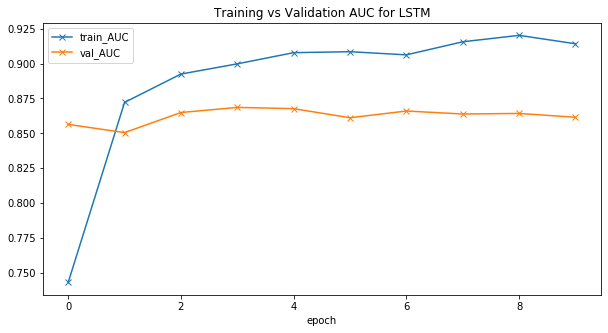

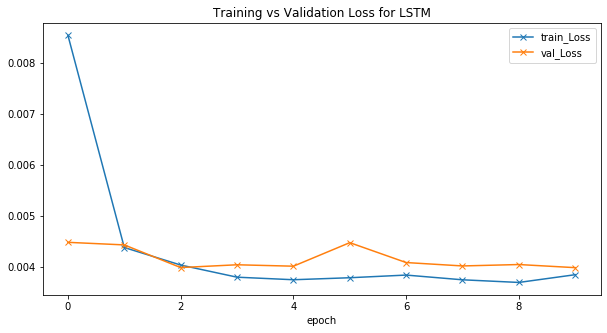

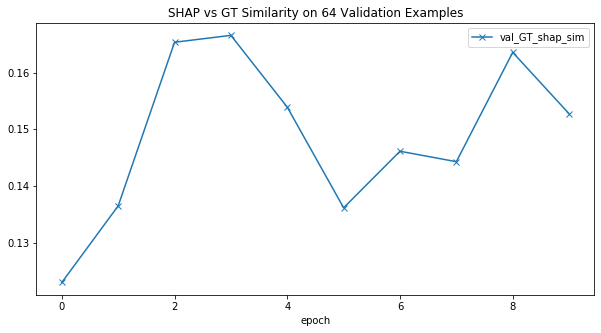

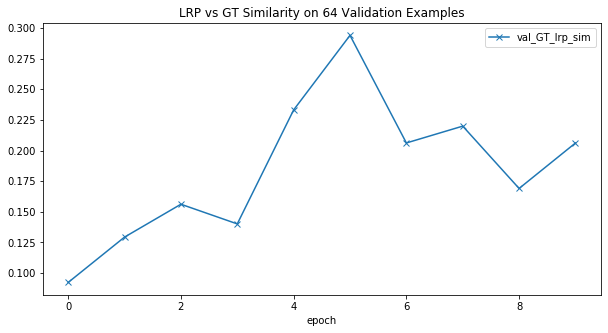

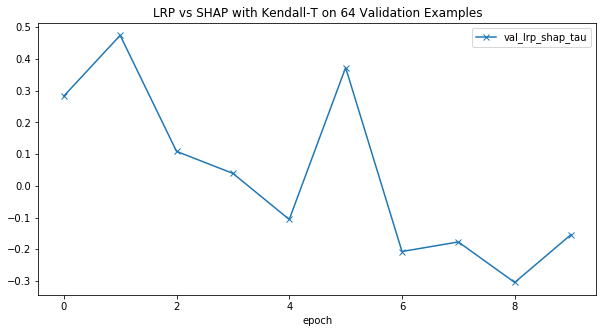

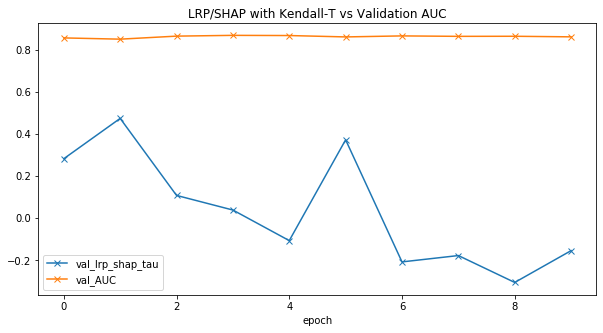

In [66]:
figsize = (10, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
)
plt.title(
    f"SHAP vs GT Similarity on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_lrp_sim"],
    kind="line",
    marker="x",
)
plt.title(
    f"LRP vs GT Similarity on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_lrp_shap_tau"],  # "val_lrp_shap_rbo", ,
    kind="line",
    marker="x",
)
plt.title(
    f"LRP vs SHAP with Kendall-T on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_lrp_shap_tau", "val_AUC"],  # "val_lrp_shap_rbo", ],
    kind="line",
    marker="x",
)
plt.title("LRP/SHAP with Kendall-T vs Validation AUC")

plt.show()

In [17]:
## Visualize SHAP

In [73]:
best_epoch = 5
selected_epochs = [best_epoch]
# selected_epochs = [1]

In [74]:
selected_patients = pd.read_csv(SELECTED_EXAMPLES_PATH, sep=" ", header=None)
selected_patients = selected_patients.values.flatten().tolist()
# selected_patients
# selected_patients = ["1OD472J277", "XEK4OM00KJ"]

In [75]:
selected_patients

['SVR2R5OW0', 'D7V9VG3RG', 'JKPBPC37C', 'MLJEL37NX']

In [76]:
example_results = {}
for pat_id in selected_patients:
    example_results[pat_id] = {}
    for epoch in range(N_EPOCHS):
        if pat_id in test_results[epoch].keys():
            example_results[pat_id][epoch] = test_results[epoch][pat_id]
example_results.keys()

dict_keys(['SVR2R5OW0', 'D7V9VG3RG', 'JKPBPC37C', 'MLJEL37NX'])

LRP for Epoch: 5


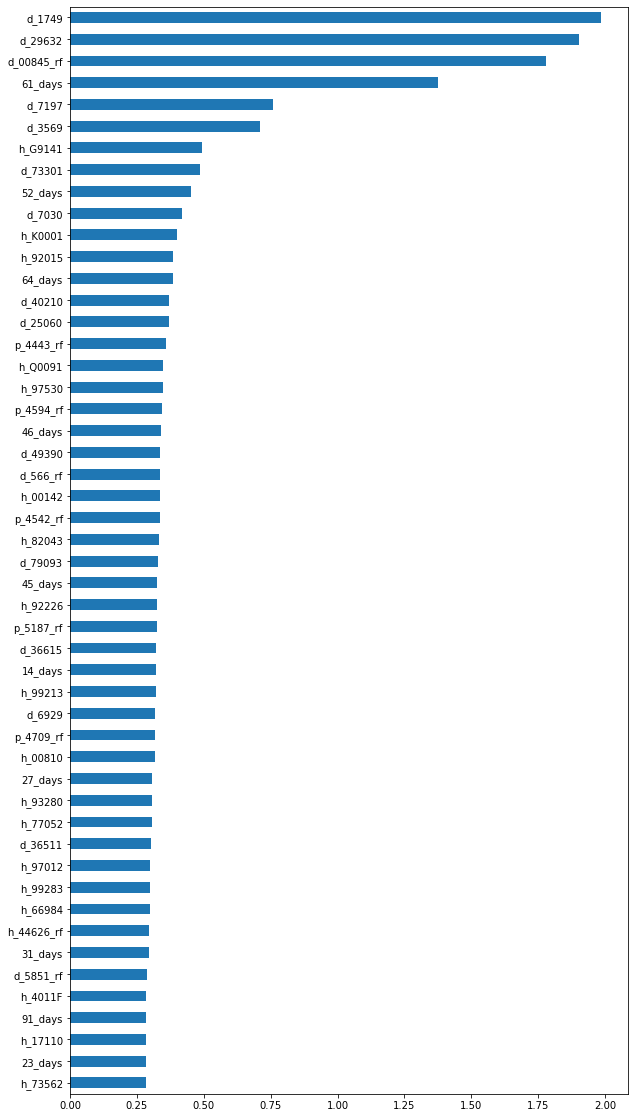

In [77]:
MAX_TOKENS = 50
# get_all_shap_scores
n_jobs = len(valid_results.keys())
step = int(n_jobs / 2) - 1
for epoch, val_scores in valid_results.items():
    if epoch != best_epoch:
        continue
    all_features = []
    all_scores = []
    for pat_id, scores in val_scores.items():
        all_scores.append(valid_results[epoch][pat_id]["imp"]["lrp_scores"].tolist())
        all_features.append(valid_results[epoch][pat_id]["imp"]["token"].tolist())
        # print(valid_results[epoch][pat_id]["imp"]["token"])
    global_scores = sj_utils.get_global_feature_importance(
        all_features, all_scores, absolute=True
    )
    print("LRP for Epoch: " + str(epoch))
    df_lrp = sj_utils.plot_global_feature_importance(
        global_scores, max_features=MAX_TOKENS
    )

SHAP for Epoch: 5


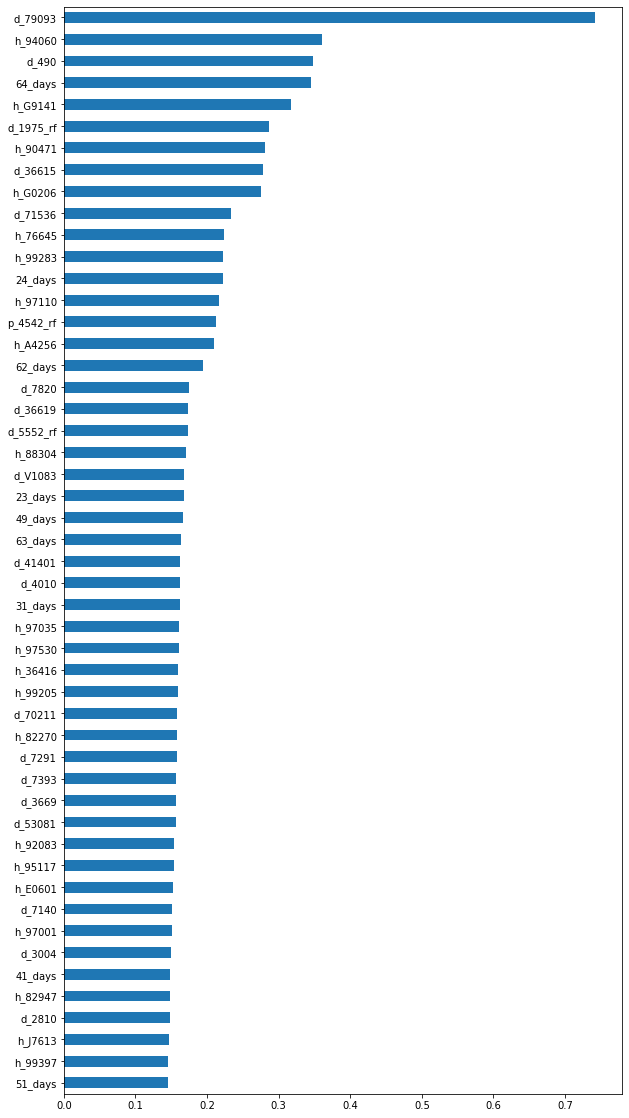

In [65]:
# get_all_shap_scores
n_jobs = len(valid_results.keys())
step = int(n_jobs / 2) - 1
for epoch, val_scores in valid_results.items():
    if epoch != best_epoch:
        continue
    all_features = []
    all_scores = []
    for pat_id, scores in val_scores.items():
        all_scores.append(valid_results[epoch][pat_id]["imp"]["shap_scores"].tolist())
        all_features.append(valid_results[epoch][pat_id]["imp"]["token"].tolist())
        # print(valid_results[epoch][pat_id]["imp"]["token"])
    global_scores = sj_utils.get_global_feature_importance(
        all_features, all_scores, absolute=True
    )
    print("SHAP for Epoch: " + str(epoch))
    df_shap = sj_utils.plot_global_feature_importance(
        global_scores, max_features=MAX_TOKENS
    )

## PLOT SHAP

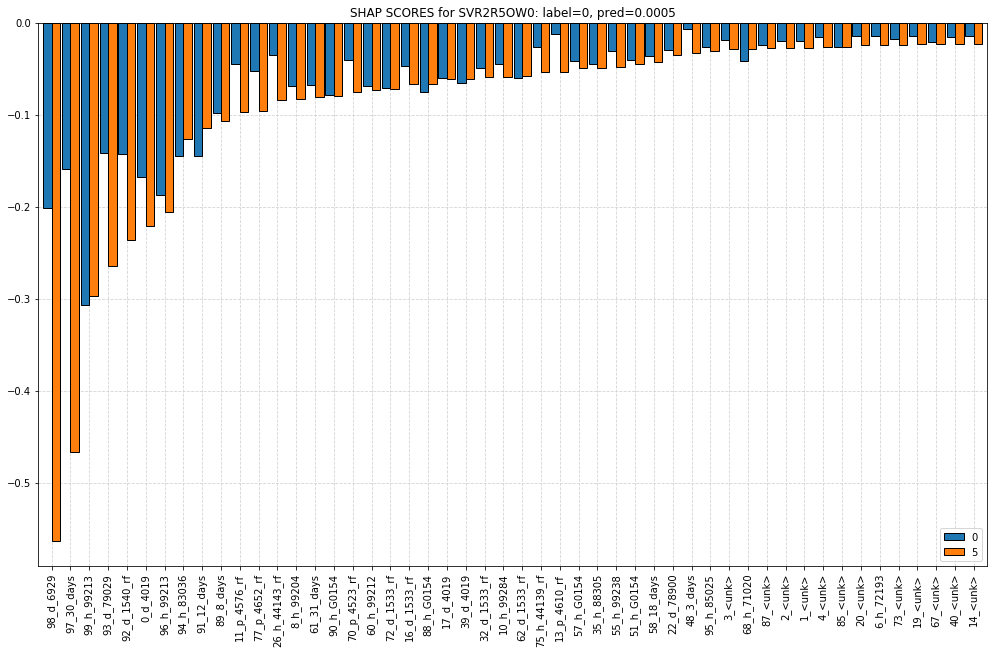

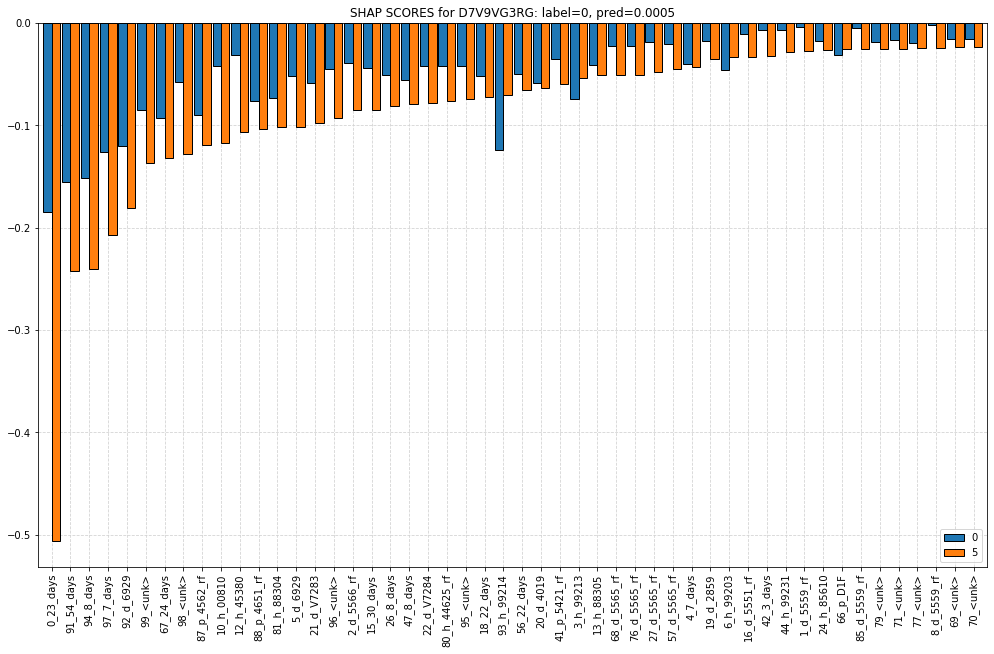

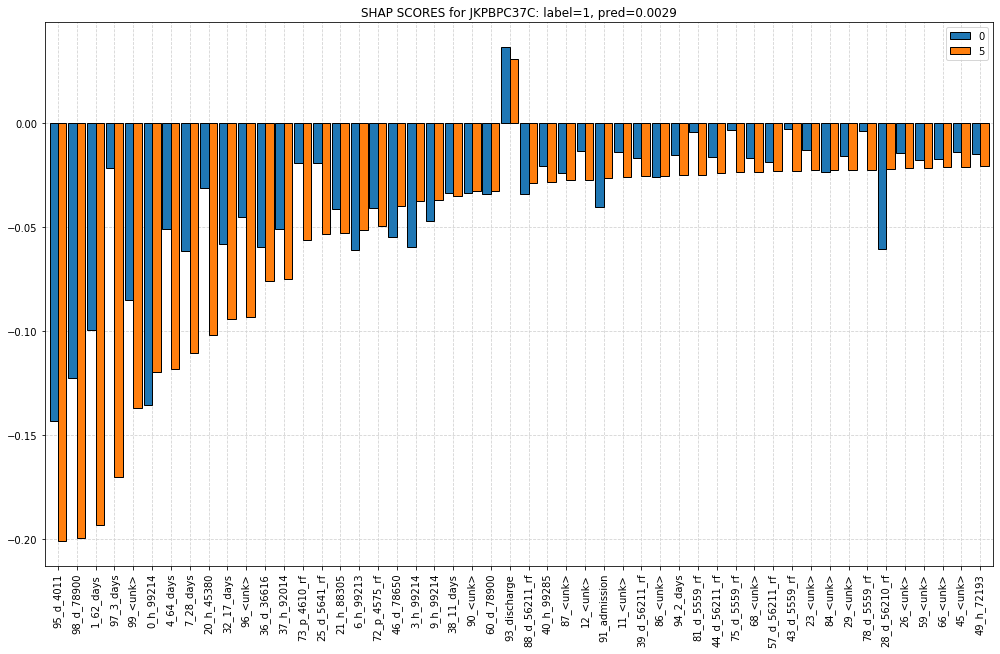

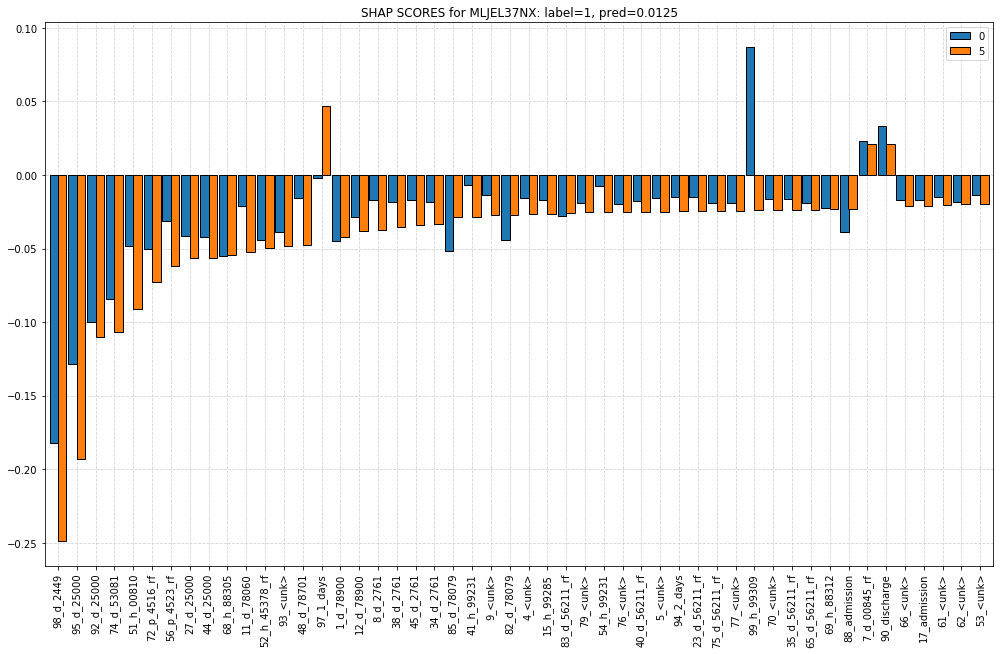

In [67]:
max_tokens = 50
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["shap_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    sorted = False
    if df.shape[0] >= max_tokens:
        idx = np.argsort(np.abs(df[selected_epochs[-1]].values))[::-1][
            :max_tokens
        ].tolist()
        df = df.iloc[idx]
        # df = df.sort_values(selected_epochs[-1], ascending=False)
        df["token"] = df["seq_idx"].astype("str") + "_" + df["token"]
        df = df.iloc[:max_tokens]
        sorted = True

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    if sorted:
        plt.xticks(range(len(df["seq_idx"])), df.token.values.tolist(), rotation=90)
    else:
        plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"SHAP SCORES for {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--")

    plt.show()

## PLOT LRP

In [39]:
plt.rcParams["axes.axisbelow"] = True

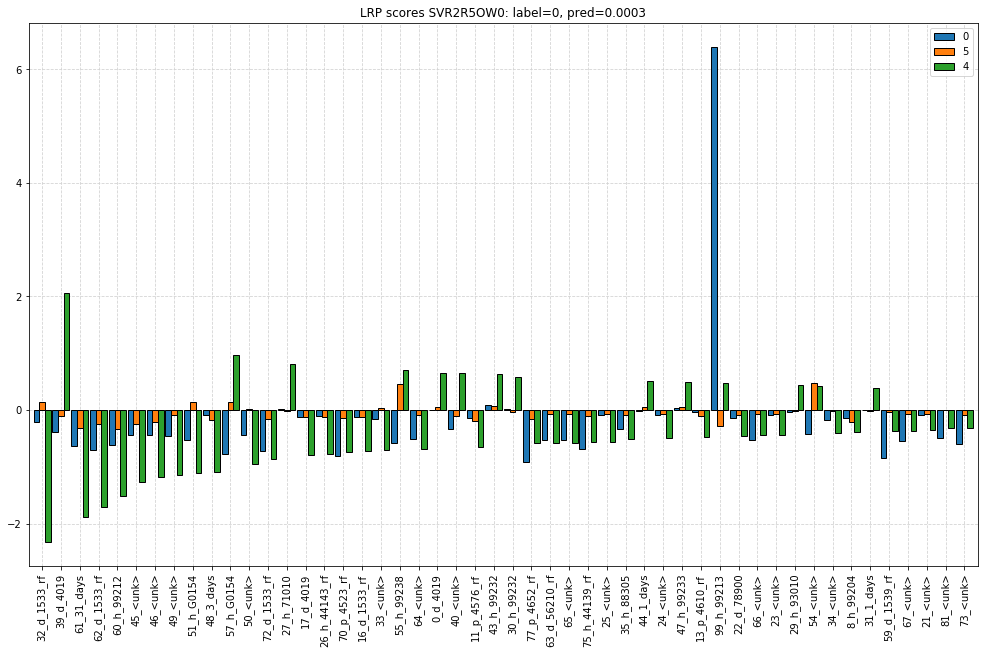

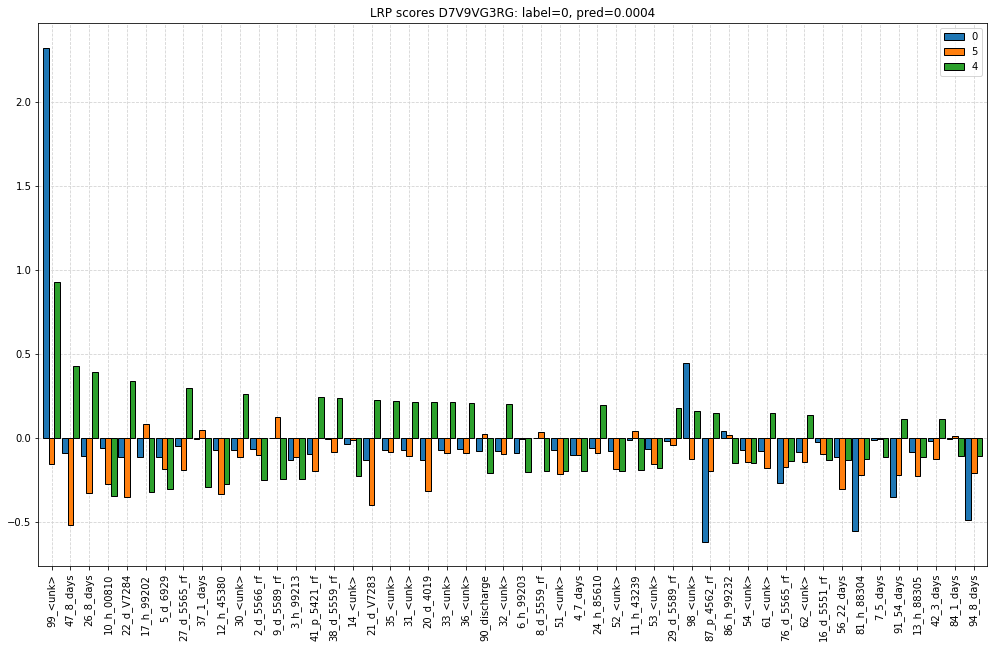

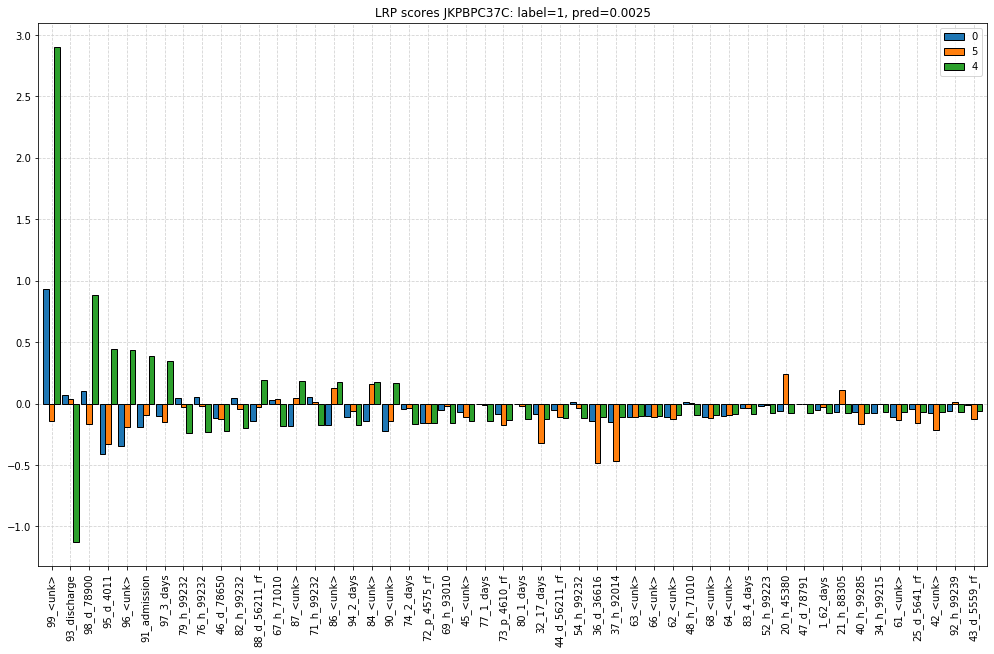

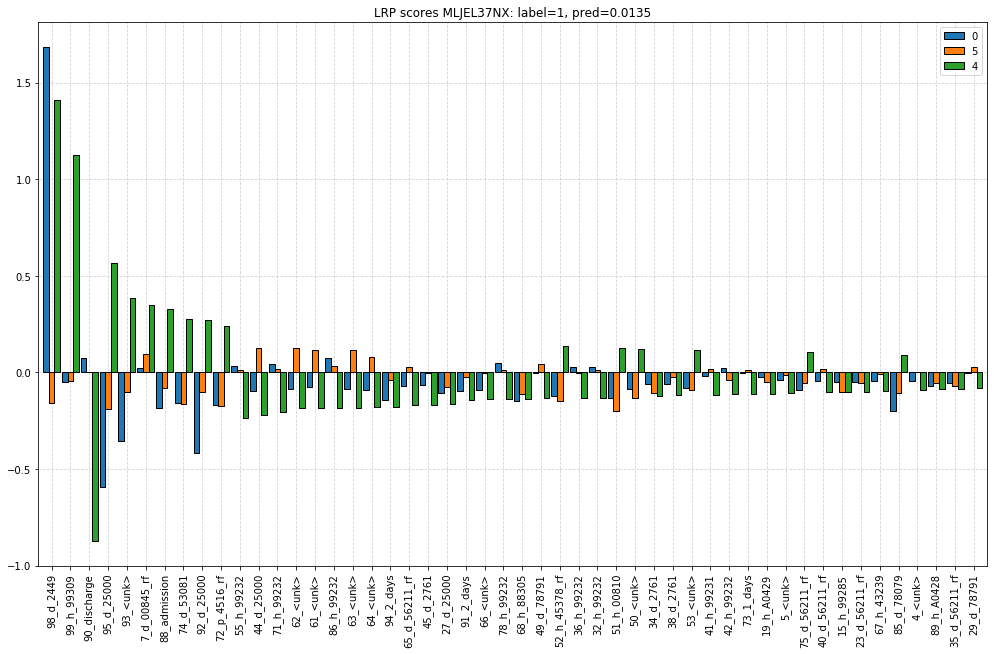

In [40]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    sorted = False
    if df.shape[0] >= max_tokens:
        idx = np.argsort(np.abs(df[selected_epochs[-1]].values))[::-1][
            :max_tokens
        ].tolist()
        df = df.iloc[idx]
        # df = df.sort_values(selected_epochs[-1], ascending=False)
        df["token"] = df["seq_idx"].astype("str") + "_" + df["token"]
        df = df.iloc[:max_tokens]
        sorted = True

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    if sorted:
        plt.xticks(range(len(df["seq_idx"])), df.token.values.tolist(), rotation=90)
    else:
        plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    #     # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    #     df[selected_epochs].plot.bar(
    #         align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    #     )
    #     plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

## PLOT LSTM LRP & SHAP, LRP & SHAP & Attention scores separately

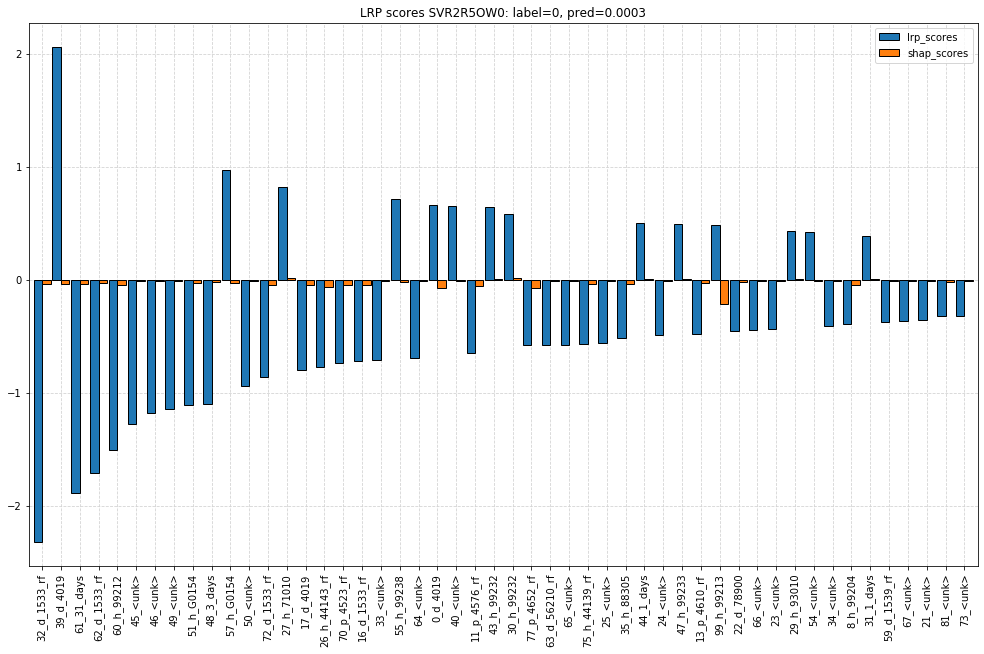

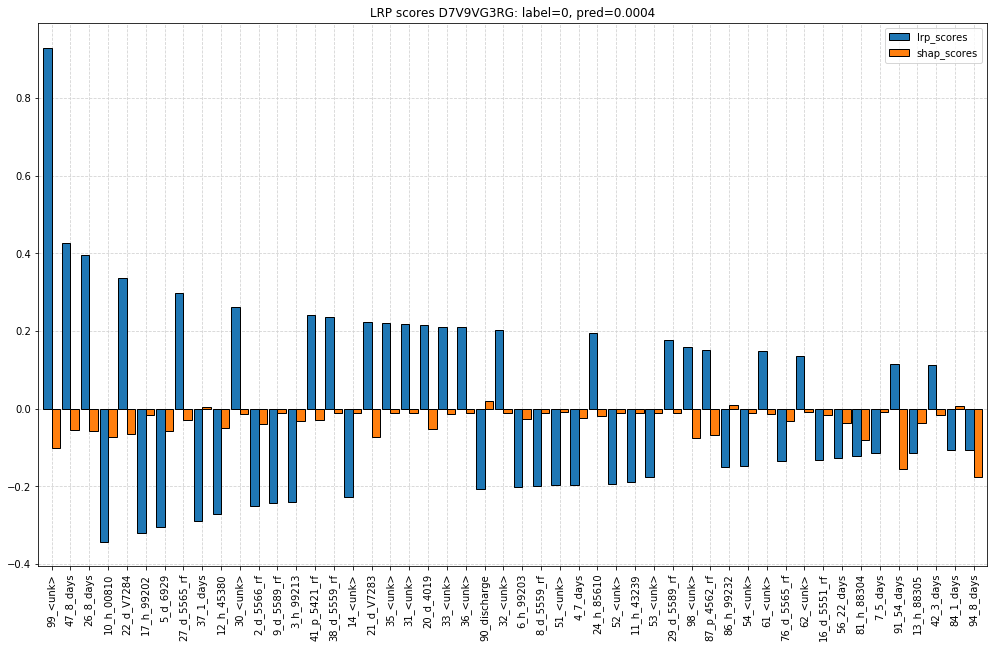

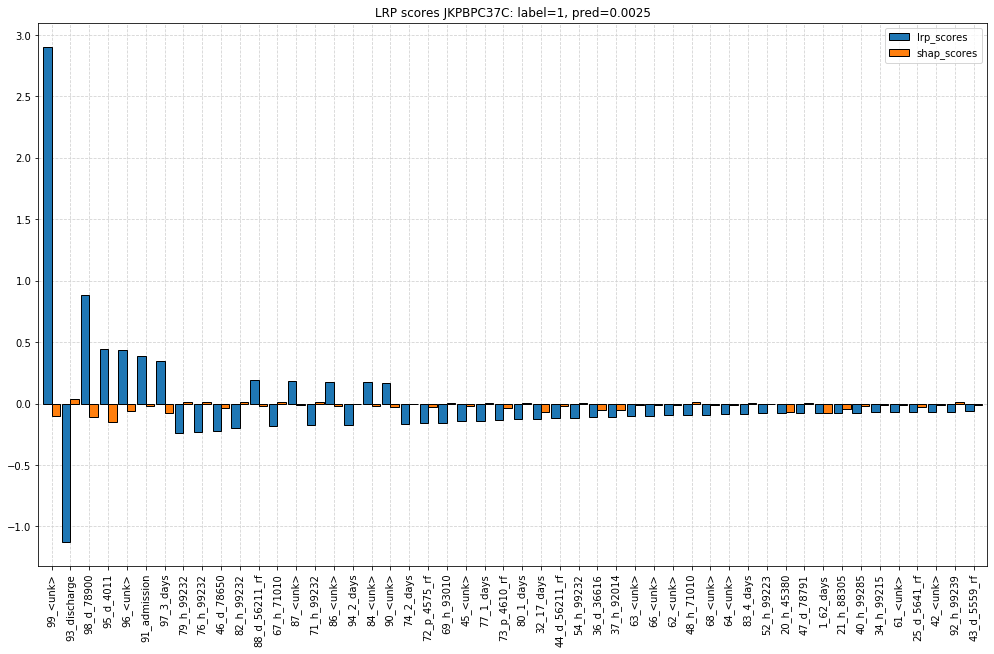

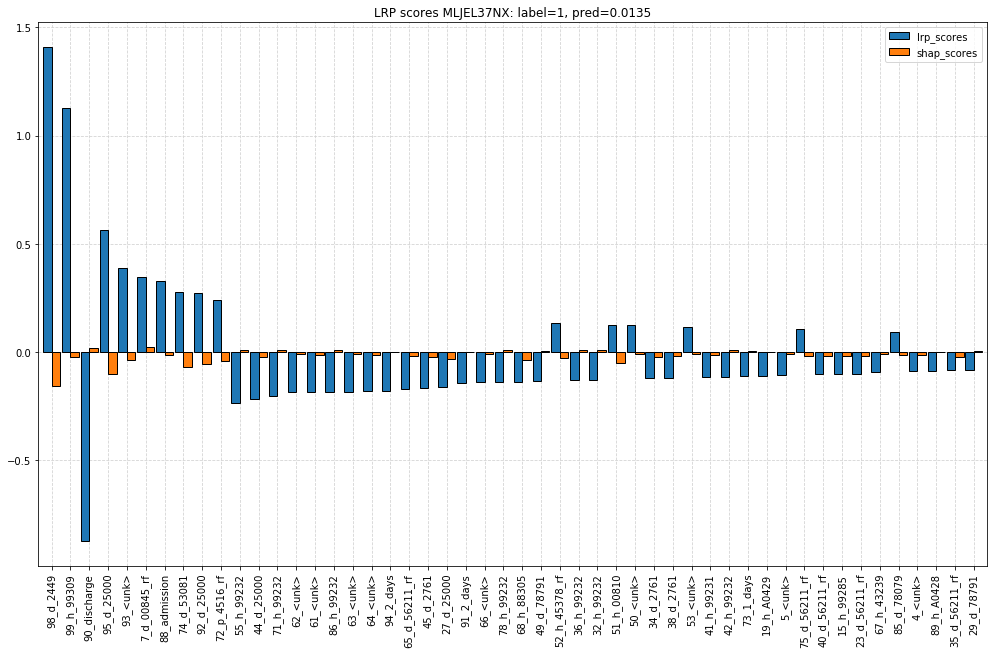

In [41]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    sorted = False
    if df.shape[0] >= max_tokens:
        idx = np.argsort(np.abs(df["lrp_scores"].values))[::-1][:max_tokens].tolist()
        df = df.iloc[idx]
        # df = df.sort_values(selected_epochs[-1], ascending=False)
        df["token"] = df["seq_idx"].astype("str") + "_" + df["token"]
        df = df.iloc[:max_tokens]
        sorted = True

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[["lrp_scores", "shap_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    if sorted:
        plt.xticks(range(len(df["seq_idx"])), df.token.values.tolist(), rotation=90)
    else:
        plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    # plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

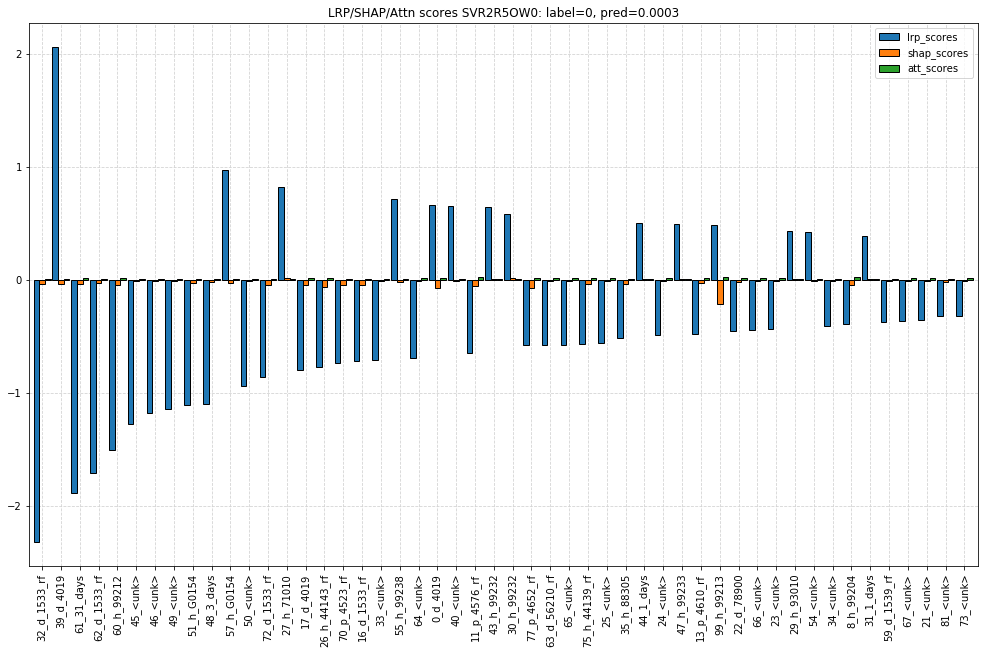

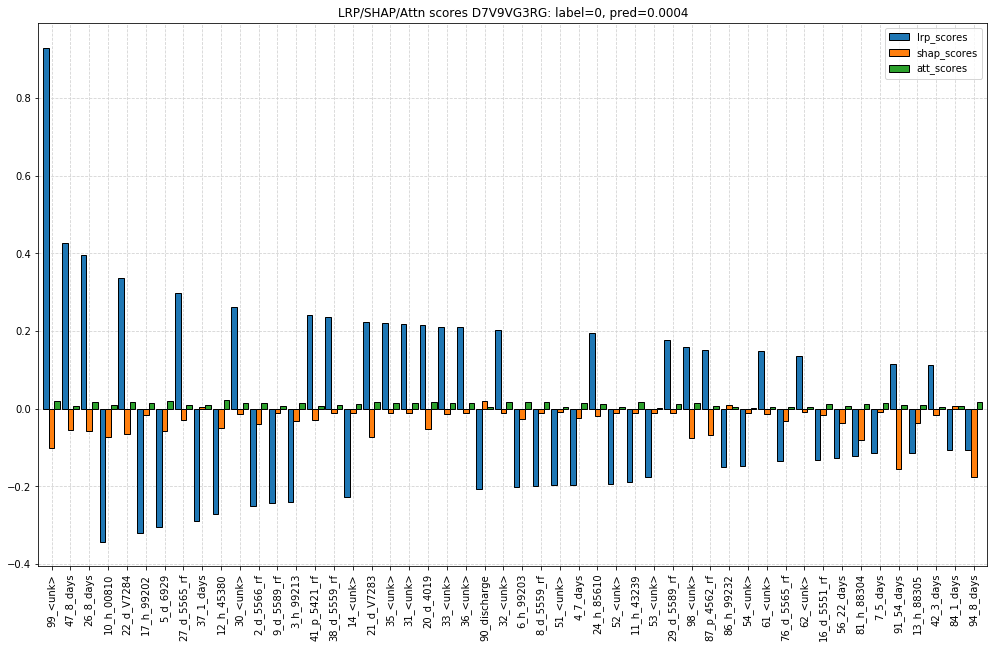

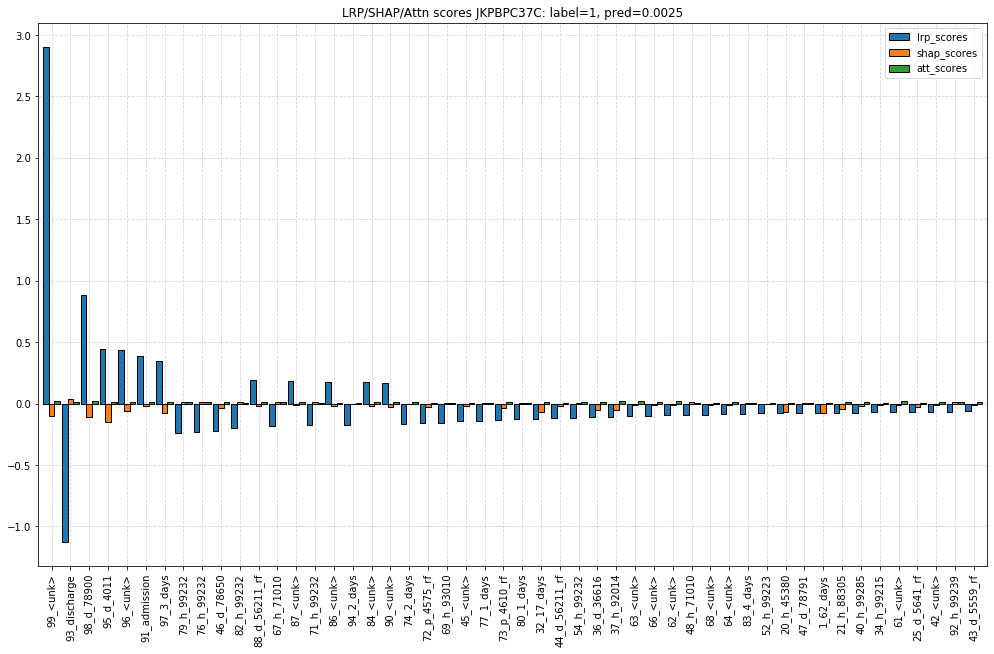

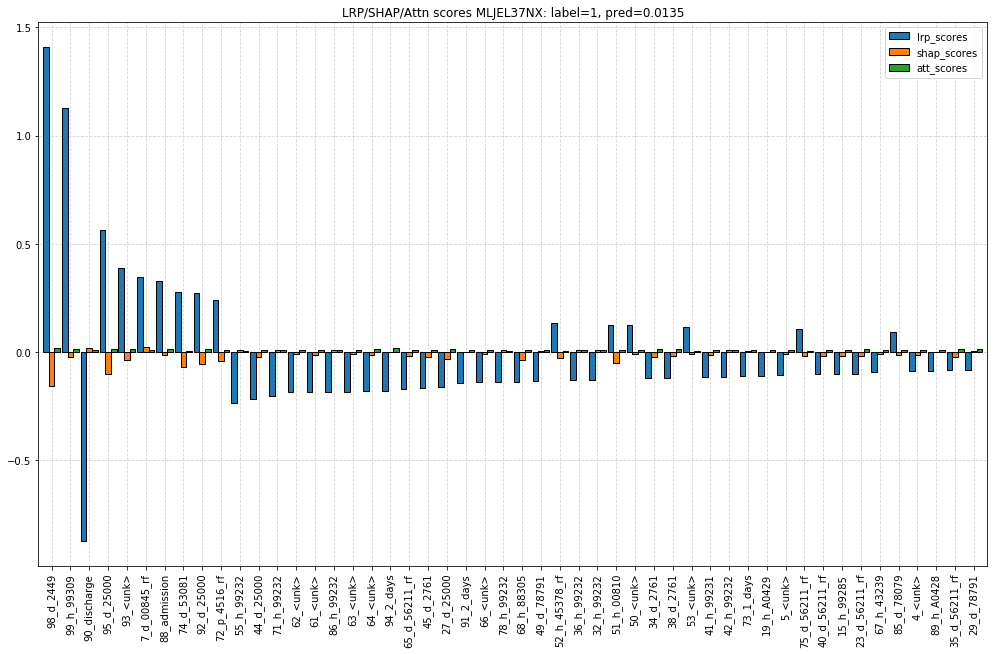

In [42]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    sorted = False
    if df.shape[0] >= max_tokens:
        idx = np.argsort(np.abs(df["lrp_scores"].values))[::-1][:max_tokens].tolist()
        df = df.iloc[idx]
        # df = df.sort_values(selected_epochs[-1], ascending=False)
        df["token"] = df["seq_idx"].astype("str") + "_" + df["token"]
        df = df.iloc[:max_tokens]
        sorted = True

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[["lrp_scores", "shap_scores", "att_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    if sorted:
        plt.xticks(range(len(df["seq_idx"])), df.token.values.tolist(), rotation=90)
    else:
        plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    # plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP/SHAP/Attn scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

### Plot LRP/SHAP with different degree of freedom of their Similarity

In [43]:
# gt_codes = pd.read_csv(GT_CODES_PATH)
# gt_codes = list(set(gt_codes.Internal_Code))
# len(gt_codes)

In [44]:
split = "val"
shap_path = SHAP_SAVE_DIR_PATTERN.format(split, best_epoch)

In [45]:
shap_path

'./output/AE_CDiff/100/original/lstm-att-lrp/20110101/20000/shap/val_shap_4.pkl'

In [46]:
with open(shap_path, "rb") as fp:
    all_scores = pickle.load(fp)
type(all_scores)

dict

In [47]:
len(all_scores)

128

In [48]:
max_freedom = 30
all_shap_sims = []
all_lrp_sims = []
for freedom in range(max_freedom):
    all_t_corr = []
    shap_sims = []
    lrp_sims = []
    for pat_id, pat_scores in all_scores.items():
        tokens = pat_scores["imp"]["u_token"]
        shap_scores = pat_scores["imp"]["shap_scores"].values
        lrp_scores = pat_scores["imp"]["lrp_scores"].values
        shap_sims.append(get_similarity(shap_scores, tokens, freedom))
        lrp_sims.append(get_similarity(lrp_scores, tokens, freedom))
        all_t_corr.append(get_wtau(shap_scores, lrp_scores))
    all_shap_sims.append(sum(shap_sims) / float(len(shap_sims)))
    all_lrp_sims.append(sum(lrp_sims) / float(len(lrp_sims)))

In [49]:
print("SHAP/LRP T-Corr:", np.array(all_t_corr).mean())

SHAP/LRP T-Corr: 0.053071441556581125


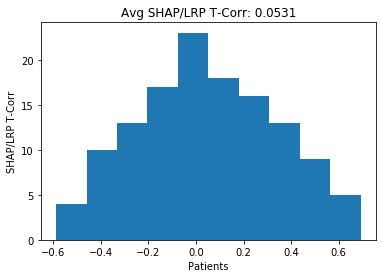

In [50]:
plt.hist(all_t_corr)
avg_t_corr = sum(all_t_corr) / float(len(all_t_corr))
plt.title(f"Avg SHAP/LRP T-Corr: {avg_t_corr:.4f}")
plt.xlabel("Patients")
plt.ylabel("SHAP/LRP T-Corr")
plt.show()

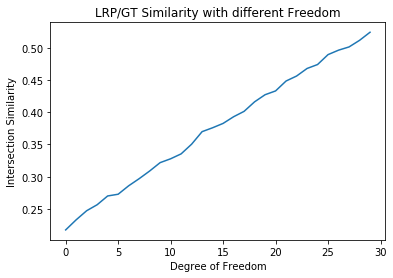

In [51]:
plt.plot(range(max_freedom), all_lrp_sims)
plt.title("LRP/GT Similarity with different Freedom")
plt.xlabel("Degree of Freedom")
plt.ylabel("Intersection Similarity")
plt.show()

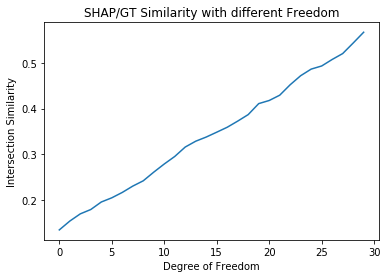

In [52]:
plt.plot(range(max_freedom), all_shap_sims)
plt.title("SHAP/GT Similarity with different Freedom")
plt.xlabel("Degree of Freedom")
plt.ylabel("Intersection Similarity")
plt.show()

In [ ]:
print(stop here)

In [ ]:
####Extra

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv(TRAIN_DATA_PATH)

In [ ]:
df_val = pd.read_csv(VALID_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:
seq_len = 50
label = "d_00845"
cols = [str(i) for i in range(seq_len - 1, -1, -1)]

In [ ]:
df_train[label].value_counts(normalize=True), df_val[label].value_counts(
    normalize=True
), df_test[label].value_counts(normalize=True),

In [ ]:
def plot_features_distribution(df, seq_len=30, split="train", normalize=True):
    """Plots distribution of features."""
    feature_names = [str(i) for i in range(seq_len - 1, -1, -1)]

    X = df[feature_names]
    y = df["d_00845"]
    y_pos_rows = y == 1
    X_pos = X[y_pos_rows]
    y_pos = y[y_pos_rows]
    y_neg_rows = y == 0
    X_neg = X[y_neg_rows]
    y_neg = y[y_neg_rows]

    freqs = dict(Counter(X.values.flatten()))
    del freqs["<pad>"]

    if normalize:
        total = sum(freqs.values(), 0.0)
        for key in freqs:
            freqs[key] = freqs[key] / total * 100.0

    freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        x=list(range(len(list(freqs.keys())))),
        y=list(freqs.values()),
        orient="v",
    )
    z = ax.set_xticklabels(list(freqs.keys()), rotation=90)

    y_label = "Frequency"
    if normalize:
        y_label += "(%)"
    plt.title(f"Features Distribution ({split} set)")
    plt.xlabel("Features")
    plt.ylabel(y_label)
    plt.show()
    return freqs

In [ ]:
val_freqs = plot_features_distribution(
    df_val, seq_len=seq_len, split="val", normalize=True
)

In [ ]:
from collections import Counter

In [ ]:
val1 = Counter(val_freqs)

In [ ]:
freqs = dict(Counter(val_freqs).most_common(30))

In [ ]:
# freqs

In [ ]:
split = "val"
ax = sns.barplot(
    x=list(range(len(list(freqs.keys())))),
    y=list(freqs.values()),
    orient="v",
)
z = ax.set_xticklabels(list(freqs.keys()), rotation=90)

y_label = "Frequency"
# if normalize:
#     y_label += "(%)"
plt.title(f"Features Distribution ({split} set)")
plt.xlabel("Features")
plt.ylabel(y_label)
plt.show()

In [ ]:
test_freqs = plot_features_distribution(
    df_test, seq_len=seq_len, split="test", normalize=True
)

In [ ]:
df_test2 = pd.read_csv(OUT_TEST_DATA_PATH)
df_test2.shape

In [ ]:
df_test2["d_00845"].value_counts()

In [ ]:
cols = ["d_00845", "num_gt_codes"]
df_test2 = df_test2.sort_values(cols, ascending=False).reset_index()
df_test2.head()

In [ ]:
idx = df_test2["d_00845"].idxmin()
idx

In [ ]:
selected = 50
my_range = range(idx, idx + selected)
print(len(my_range))
df0 = df_test2.iloc[my_range]
df = df_test2.copy()


In [ ]:
df0.shape, df.shape

In [ ]:
df0["d_00845"].value_counts()

In [ ]:
df.drop(my_range, inplace=True)
df.shape

In [ ]:
df2 = pd.ZZconcat([df0])

In [ ]:
df2.head()

In [ ]:
def rearrange(df_in, num_selected=50):
    """Take out some rows of negative examples and place them at the beginning."""
    df = df_in.copy()
    cols = ["d_00845", "num_gt_codes"]
    df = df.sort_values(cols, ascending=False).reset_index(drop=True)
    idx = df["d_00845"].idxmin()
    my_range = range(idx, idx + num_selected)
    df0 = df.iloc[my_range]
    df = df.copy()

    df.drop(my_range, inplace=True)
    df = pd.concat([df0, df]).reset_index(drop=True)
    return df

In [ ]:
df_out = rearrange(df_test2, num_selected=5)
df_out.head(20)

In [ ]:
df_test2.head()

In [ ]:
cols = ["d_00845", "num_gt_codes"]

df = df_test2.sort_values(["has_gt_codes"], ascending=False).head(100)[cols]

In [ ]:
df.value_counts(cols[0])

In [ ]:
df_test2.shape

In [ ]:
df_val = pd.read_csv(OUT_VALID_DATA_PATH)
df_test = pd.read_csv(OUT_TEST_DATA_PATH)

In [ ]:
df_val["d_00845"].value_counts()

In [ ]:
df_test["d_00845"].value_counts()

In [ ]:
df_val.head()

In [ ]:
df_val["d_00845"].idxmax()

In [ ]:
df_val.iloc[271:].head()

In [ ]:
df_val1 = df_val[df_val["d_00845"] == 1]
print(df_val1.shape)
df_val1.head()

In [ ]:
df_val2 = df_val.sort_values(["num_gt_codes", "d_00845"], ascending=False).reset_index()

In [ ]:
df_val2["d_00845"].idxmax()

In [ ]:
df_val2.iloc[48:].head(10)

In [ ]:
df_val2.shape